<a href="https://colab.research.google.com/github/rodrigobivarazevedo/machine_learning/blob/main/cnn_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [16]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
11.061084047999884
GPU (s):
0.36190356299994164
GPU speedup over CPU: 30x


In [17]:
# Are we using a GPU? If not: go to Runtime -> Change runtime type -> Hardware accelerator: GPU
!nvidia-smi

Sun Mar 30 12:03:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             26W /   70W |    1206MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import zipfile

# Unzip the downloaded file
def unzip_data(filename):
  """
  Utility function to unzip a zipped file.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [22]:
!ls -al

total 40020
drwxr-xr-x 1 root root     4096 Mar 30 12:03 .
drwxr-xr-x 1 root root    61440 Mar 30 12:01 ..
drwxr-xr-x 4 root root     4096 Mar 24 13:34 .config
-rw-r--r-- 1 root root 40894464 Mar 30 12:06 dataset_dogs_vs_cats.zip
drwx------ 6 root root     4096 Mar 30 11:56 drive
drwxr-xr-x 1 root root     4096 Mar 24 13:34 sample_data


In [3]:
unzip_data("/content/drive/MyDrive/dataset_dogs_vs_cats.zip")

# Helper Funtions

#### Load Data

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth
import numpy as np

def data_augmentation_object():
    return keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomHeight(0.2),
        RandomWidth(0.2),
    ], name="data_augmentation")

def print_class_distribution(dataset, dataset_name):
    class_counts = dataset.classes
    class_indices = dataset.class_indices
    unique_classes, counts = np.unique(class_counts, return_counts=True)
    print(f"Class distribution for {dataset_name}:")
    for class_idx, count in zip(unique_classes, counts):
        print(f"  Class {class_idx}: {count} samples")
    print(f"  Class indices: {class_indices}")
    print(f"  Class distribution (as percentages):")
    for class_idx, count in zip(unique_classes, counts):
        percentage = (count / len(class_counts)) * 100
        print(f"    Class {class_idx}: {percentage:.2f}%")
    print("-")


def data_preprocessing(train_dataset_path="dataset_dogs_vs_cats/train",
                       test_dataset_path="dataset_dogs_vs_cats/test",
                       img_size=(128, 128),
                       batch_size=32,
                       class_mode="binary"):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_data = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset="training"
    )

    val_data = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset="validation"
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_data = test_datagen.flow_from_directory(
        test_dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=False
    )

    print_class_distribution(train_data, "Training Set")
    print_class_distribution(val_data, "Validation Set")
    print_class_distribution(test_data, "Test Set")

    return train_data, val_data, test_data


#### Prepare Image and Predict

In [98]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os


# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=False):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    # Rescale the image (get all values between 0 and 1)
    if scale:
      return img/255.
    else:
      return img

def predict_image(img_path, model, img_size=224):

    class_names = ['cats', 'dogs']

    img_array = load_and_prep_image(img_path)
    img_expanded = tf.expand_dims(img_array, axis=0) # expand image dimensions (224, 224, 3) -> (1, 224, 224, 3)

    pred_probs = model.predict(img_expanded)
    pred_class = class_names[tf.argmax(pred_probs[0])]

    print(f"Prediction: {pred_class} with {tf.reduce_max(pred_probs):.2f} confidence")


    image = tf.cast(tf.round(img_array), dtype=tf.int32)

    plt.figure()
    plt.imshow(image) # img[0].numpy().astype("uint8")
    plt.title(f"{pred_class}, prob: {tf.reduce_max(pred_probs):.2f}")
    plt.axis(False);

    return pred_class, pred_probs


#### Model Training Function

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_model(model, train_data, val_data, epochs=10):
    """
    Trains the model using the provided training and validation data.
    """

    # Define callbacks for better training
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_loss',
        patience=2,
        factor=0.5,
        min_lr=1e-6
    )

    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping, learning_rate_reduction]
    )

    return history

#### Evaluate Model Functions

In [89]:
import matplotlib.pyplot as plt

def plot_train_validation_history(history):
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

def get_model_metrics(model, test_data):
    """
    Evaluates a classification model using test data, prints a classification report,
    and plots a confusion matrix.

    Parameters:
    - model: Trained Keras model
    - test_data: Test dataset (should be a tf.data.Dataset)
    """

    y_true = []
    y_pred_probs = []

    for images, labels in test_data:
        y_true.extend(labels.numpy())  # Convert Tensor to NumPy array and store
        y_pred_probs.extend(model.predict(images))  # Get predictions

    y_true = np.array(y_true)  # Convert list to NumPy array
    y_pred_probs = np.array(y_pred_probs)  # Convert list to NumPy array

    # If y_true is one-hot encoded, convert it to class labels
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class labels

    # Determine if it's binary or multi-class classification
    num_classes = model.output_shape[-1]

    if num_classes == 1:
        # Binary classification (sigmoid activation)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    else:
        # Multi-class classification (softmax activation)
        y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get unique class names dynamically
    class_names = [str(i) for i in np.unique(y_true)]

    # Print classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    # Compute precision and recall
    if num_classes == 1:
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
    else:
        precision = precision_score(y_true, y_pred, average="weighted")
        recall = recall_score(y_true, y_pred, average="weighted")

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()




# Efficient Net Model

1. Real-time Augmentation During Training
On-the-fly augmentation: Each time an image is passed through the model during training, the augmentation will be applied. This means your model sees different versions of the same image during each epoch, helping it generalize better.
Efficiency: This method allows augmentation to be part of the model graph, enabling efficient GPU computation and possibly reducing memory usage since augmented images aren't saved on disk but created in memory during training.
2. Applied Only to the Training Data
No augmentation for validation and test data: The augmentation layer will be applied only during training, so the validation and test datasets remain unchanged (no augmentation). This ensures that model evaluation is based on the original data, providing an accurate assessment of its performance.

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Setup input shape and base model, freezing the base model layers
INPUT_SHAPE = (224, 224, 3)
BASE_MODEL = tf.keras.applications.EfficientNetB0(include_top=False)

def create_EfficientNet_model(input_shape=INPUT_SHAPE, base_model=BASE_MODEL, num_classes=1):


    # Create a data augmentation stage with horizontal flipping, rotations, zooms
    data_augmentation = keras.Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.2),
            RandomZoom(0.2),
            RandomHeight(0.2),
            RandomWidth(0.2),
        ], name="data_augmentation")

    # Freeze base model layers
    base_model.trainable = False

    # Create input layer
    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Add in data augmentation Sequential model as a layer (ensure it's defined elsewhere)
    x = data_augmentation(inputs)

    # Pass inputs through base model (without training it)
    x = base_model(x, training=False)

    # Pool output features
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

    # Output layer for binary classification
    outputs = layers.Dense(num_classes, activation="sigmoid", name="output_layer")(x)

    # Create model
    model = keras.Model(inputs, outputs)

    # Compile the model for binary classification
    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall() ])

    return model


In [38]:
# Setup data inputs
IMG_SIZE = (224, 224)

def create_data_loaders(train_dir, test_dir, image_size=IMG_SIZE):
  """
  Creates a training and test image BatchDataset from train_dir and test_dir.
  """
  train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)
  # Note: the test data is the same as the previous experiment, we could
  # skip creating this, but we'll leave this here to practice.
  test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)

  return train_data, test_data

In [76]:
train_data, test_data = create_data_loaders(train_dir="dataset_dogs_vs_cats/train/",
                                            test_dir="dataset_dogs_vs_cats/test")

Found 14874 files belonging to 2 classes.
Found 5023 files belonging to 2 classes.


In [40]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [41]:
model_1 = create_EfficientNet_model(num_classes=len(train_data.class_names))

# Fit the model
history_1_percent = model_1.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "all_data_aug")])

Saving TensorBoard log files to: transfer_learning/all_data_aug/20250330-123413
Epoch 1/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 67s 118ms/step - accuracy: 0.9280 - loss: 0.2164 - precision_5: 0.9274 - recall_5: 0.9115 - val_accuracy: 0.9952 - val_loss: 0.0290 - val_precision_5: 0.9944 - val_recall_5: 0.9944
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - accuracy: 0.9711 - loss: 0.0793 - precision_5: 0.9710 - recall_5: 0.9696 - val_accuracy: 0.9944 - val_loss: 0.0228 - val_precision_5: 0.9944 - val_recall_5: 0.9944
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - accuracy: 0.9762 - loss: 0.0647 - precision_5: 0.9757 - recall_5: 0.9759 - val_accuracy: 0.9936 - val_loss: 0.0244 - val_precision_5: 0.9936 - val_recall_5: 0.9944
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 142s 176ms/step - accuracy: 0.9767 - loss: 0.0646 - precision_5: 0.9761 - recall_5: 0.9766 - val_accuracy: 0.9944 - val_loss: 0.0218 - val_precision_5: 0.9936 - val_recall_5: 0.9936
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 

# Validation and Train accuracy Plot

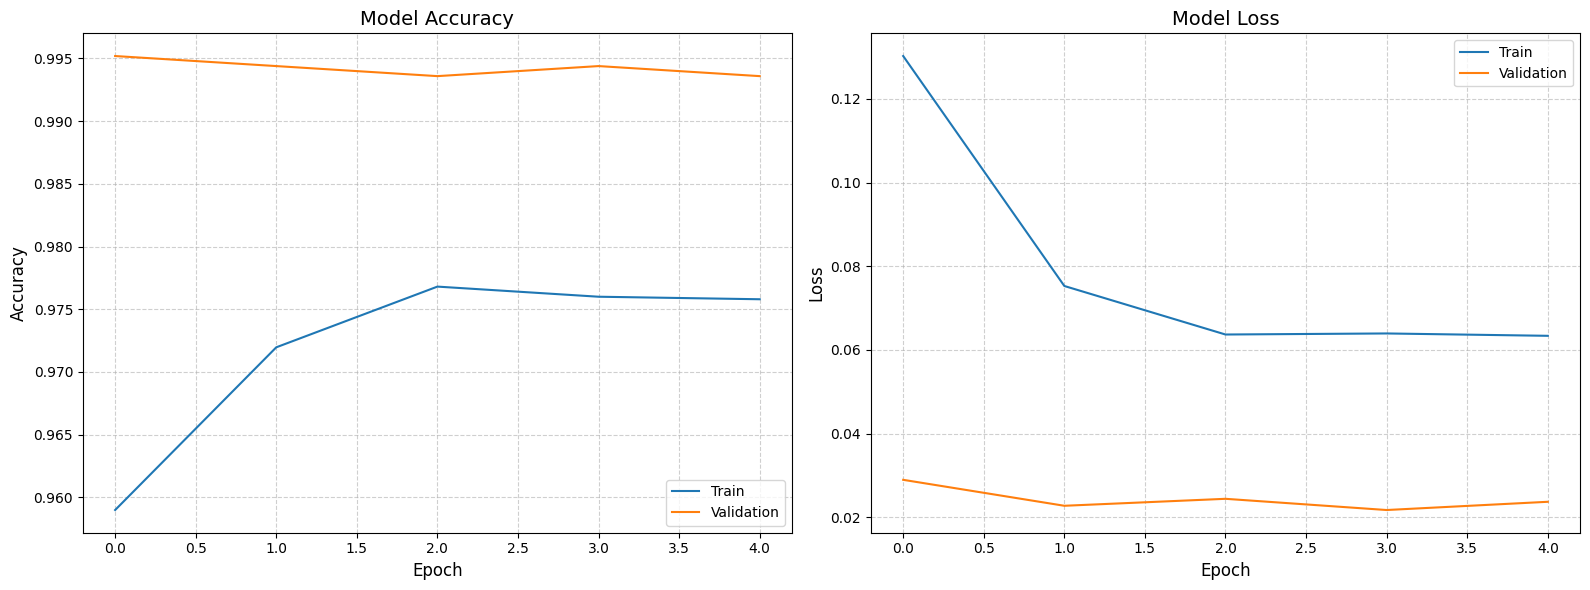

In [69]:
plot_train_validation_history(history_1_percent)

# Model Metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms

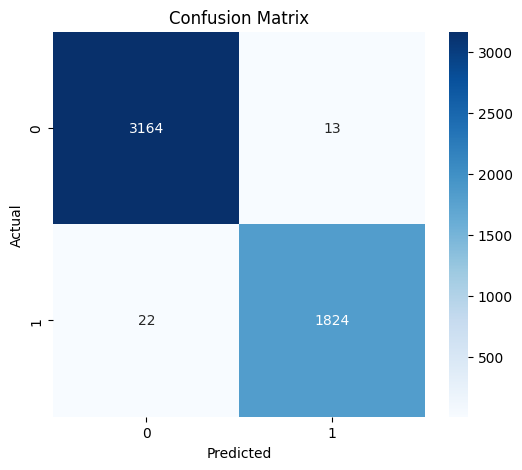

In [90]:
get_model_metrics(model_1, test_data)

# Predict a DOG

In [91]:
img_array = load_and_prep_image("/content/drive/MyDrive/rosita.jpg")
img_array

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 72.36376 ,  60.930725,  51.930725],
        [ 69.72519 ,  55.930046,  47.725185],
        [ 68.91781 ,  50.372505,  46.05174 ],
        ...,
        [106.50494 ,  87.91071 ,  77.51791 ],
        [ 95.40646 ,  83.15491 ,  74.67723 ],
        [ 94.78895 ,  78.74257 ,  67.2743  ]],

       [[ 75.421135,  65.649315,  51.69396 ],
        [ 76.757454,  59.028282,  49.028282],
        [ 68.22321 ,  49.223213,  43.370018],
        ...,
        [ 90.306595,  80.492195,  78.712494],
        [ 90.3571  ,  83.03559 ,  80.03559 ],
        [ 99.578354,  90.72911 ,  83.8045  ]],

       [[ 77.56565 ,  64.00446 ,  55.808693],
        [ 88.35413 ,  68.53966 ,  59.910717],
        [ 75.97816 ,  59.13652 ,  52.395447],
        ...,
        [ 94.35927 ,  78.712   ,  73.60419 ],
        [ 88.835106,  77.377754,  69.439835],
        [ 77.32775 ,  63.55097 ,  57.93936 ]],

       ...,

       [[131.52368 , 129.68056 , 129.16528 ],
        [132.

In [92]:
# Classes our model is trained on
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [93]:
# Make predictions
img_expanded = tf.expand_dims(img_array, axis=0) # expand image dimensions (224, 224, 3) -> (1, 224, 224, 3)
pred = model_1.predict(img_expanded)
pred

class_names[tf.argmax(pred[0])]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


'dogs'

# Predict a CAT

In [97]:
class_names = ['cats', 'dogs']
img_path = "/content/drive/MyDrive/cat.0.jpg"
img_array = load_and_prep_image(img_path)
img_expanded = tf.expand_dims(img_array, axis=0) # expand image dimensions (224, 224, 3) -> (1, 224, 224, 3)
pred = model_1.predict(img_expanded)
class_names[tf.argmax(pred[0])]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


'cats'

# Test with my own dogs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: dogs with 1.00 confidence


('dogs', array([[0.00210875, 0.9972723 ]], dtype=float32))

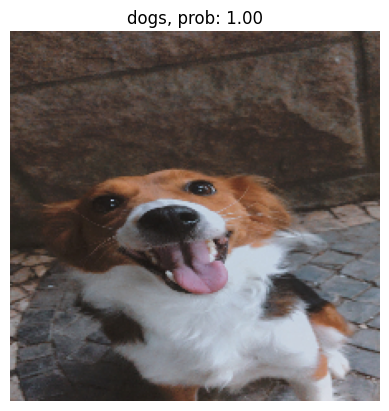

In [99]:
img_path = "/content/drive/MyDrive/rosita.jpg"

predict_image(img_path, model_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Prediction: dogs with 0.98 confidence


('dogs', array([[0.02732119, 0.98174125]], dtype=float32))

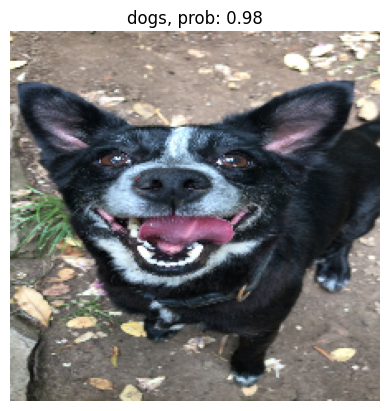

In [101]:
img_path = "/content/drive/MyDrive/risca.jpg"

predict_image(img_path, model_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: cats with 1.00 confidence


('cats', array([[0.9985361 , 0.00120674]], dtype=float32))

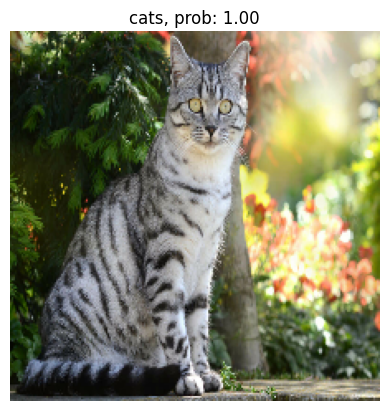

In [100]:
img_path = "/content/drive/MyDrive/cat.0.jpg"

predict_image(img_path, model_1)

In [102]:
train_data, val_data, test_data = data_preprocessing(train_dataset_path="dataset_dogs_vs_cats/train",
                       test_dataset_path="dataset_dogs_vs_cats/test",
                       img_size=(224, 224),
                       batch_size=32,
                       class_mode="binary")

Found 11900 images belonging to 2 classes.
Found 2974 images belonging to 2 classes.
Found 5023 images belonging to 2 classes.
Class distribution for Training Set:
  Class 0: 7459 samples
  Class 1: 4441 samples
  Class indices: {'cats': 0, 'dogs': 1}
  Class distribution (as percentages):
    Class 0: 62.68%
    Class 1: 37.32%
-
Class distribution for Validation Set:
  Class 0: 1864 samples
  Class 1: 1110 samples
  Class indices: {'cats': 0, 'dogs': 1}
  Class distribution (as percentages):
    Class 0: 62.68%
    Class 1: 37.32%
-
Class distribution for Test Set:
  Class 0: 3177 samples
  Class 1: 1846 samples
  Class indices: {'cats': 0, 'dogs': 1}
  Class distribution (as percentages):
    Class 0: 63.25%
    Class 1: 36.75%
-


In [104]:
model_2 = create_EfficientNet_model(num_classes=1)

In [ ]:
train_model(model_2, train_data, val_data, epochs=5)

In [ ]:
history_2 = model_2.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "all_data_aug")])

Saving TensorBoard log files to: transfer_learning/all_data_aug/20250330-131945


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


# Binary CNN model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


def create_binary_cnn_model(data_augmentation, input_shape=(224, 224, 3)):

    # Define CNN model
    model = Sequential([
        # Apply Augmentation as a Preprocessing Layer in the Model
        data_augmentation,

        # First convolutional block
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2,2)),

        # Second convolutional block
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),

        # Third convolutional block
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),

        # Fully connected layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model for binary classification
    model.compile(loss="binary_crossentropy",
                 optimizer='adam',
                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    model.summary()

    return model

# Model 3 - MobileNet ransfer learning

MobileNetV2 is a convolutional neural network architecture designed for mobile and edge devices. It was introduced by Google researchers in 2018 as an improvement over the original MobileNet architecture.
Key characteristics of MobileNetV2:

Efficiency: It's specifically designed to be lightweight and computationally efficient, making it suitable for mobile devices, embedded systems, and edge computing.
Architecture Features:

Uses depthwise separable convolutions (which split standard convolutions into depthwise and pointwise convolutions)
Introduces an inverted residual structure where the residual connections are between the bottleneck layers
Implements linear bottlenecks between layers to prevent information loss


Performance: Despite being lightweight, it achieves good accuracy on image classification tasks. It strikes an excellent balance between model size, speed, and accuracy.
Pre-trained Weights: It comes with pre-trained weights on the ImageNet dataset, which makes it excellent for transfer learning (where you take a pre-trained model and fine-tune it for your specific task).
Use Cases: Common applications include image classification, object detection, and segmentation on resource-constrained devices.

#### Create MobileNet Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Setup input shape and base model, freezing the base model layers
INPUT_SHAPE = (224, 224, 3)

def create_EfficientNet_model(input_shape=INPUT_SHAPE, num_classes=1):

    data_augmentation = keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomHeight(0.2),
        RandomWidth(0.2),
    ], name="data_augmentation")

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers
    base_model.trainable = False

    # Create input layer
    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Add in data augmentation Sequential model as a layer (ensure it's defined elsewhere)
    x = data_augmentation(inputs)

    # Pass inputs through base model (without training it)
    x = base_model(x, training=False)

    # Pool output features
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

    # Output layer for binary classification
    outputs = layers.Dense(num_classes, activation="sigmoid", name="output_layer")(x)

    # Create model
    model = keras.Model(inputs, outputs)

    # Compile the model for binary classification
    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall() ])

    return model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

# Transfer learning with MobileNetV2
def create_transfer_learning_model(data_augmentation, img_size=(128, 128)):

    data_augmentation = keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomHeight(0.2),
        RandomWidth(0.2),
    ], name="data_augmentation")

    # Load the pretrained model
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(*img_size, 3)
    )

    # Freeze the base model (no fine-tuning)
    base_model.trainable = False

    # Create new model on top
    model = Sequential([
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile model with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Model summary
    model.summary()

    return model



In [ ]:
train_data, val_data, test_data = data_preprocessing()

In [ ]:
model = create_transfer_learning_model()

# Define callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[early_stopping, learning_rate_reduction]
)

test_results = model.evaluate(test_data, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print(f"Test F1-Score: {2 * (test_results[2] * test_results[3]) / (test_results[2] + test_results[3]):.4f}")

# Model 4 - more layers

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Advanced CNN model from scratch
def create_custom_model(data_augmentation, img_size=(224, 224)):
    model = Sequential([

        # Apply augmentation before passing to the base model
        data_augmentation,

        # First convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(*img_size, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fourth convolutional block
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model